In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import string
import re
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from pylab import rcParams
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error
from stoch_gradient_descent import StochasticGradientDescent

%matplotlib inline

sns.set(style='whitegrid', palette='muted')

rcParams['figure.figsize'] = 14, 10
RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)

### Here we read the user artist file and artist file, for artist we only want the id and name of the artist

In [2]:
plays = pd.read_csv('./data/user_artists.dat', sep='\t')
artists = pd.read_csv('./data/artists.dat', sep='\t', usecols=['id', 'name'])

In [3]:
plays.head(10)

,userID,artistID,weight
0,2,51,13883
1,2,52,11690
2,2,53,11351
3,2,54,10300
4,2,55,8983
5,2,56,6152
6,2,57,5955
7,2,58,4616
8,2,59,4337
9,2,60,4147


In [4]:
artists.head(10)

,id,name
0,1,MALICE MIZER
1,2,Diary of Dreams
2,3,Carpathian Forest
3,4,Moi dix Mois
4,5,Bella Morte
5,6,Moonspell
6,7,Marilyn Manson
7,8,DIR EN GREY
8,9,Combichrist
9,10,Grendel


### Merging the two dataframes to get the artist rakings based on number of plays

In [5]:
ap = pd.merge(artists, plays, how='inner', left_on='id', right_on='artistID')
ap = ap.rename(columns={"weight": 'totalPlay'})
ap.head(10)

,id,name,userID,artistID,totalPlay
0,1,MALICE MIZER,34,1,212
1,1,MALICE MIZER,274,1,483
2,1,MALICE MIZER,785,1,76
3,2,Diary of Dreams,135,2,1021
4,2,Diary of Dreams,257,2,152
5,2,Diary of Dreams,325,2,3466
6,2,Diary of Dreams,397,2,56
7,2,Diary of Dreams,560,2,134
8,2,Diary of Dreams,580,2,803
9,2,Diary of Dreams,935,2,428


In [6]:
artist_rank = ap.groupby(['name'])\
              .agg({'userID': 'count', 'totalPlay': 'sum'})\
              .rename(columns={"userID": 'totalUniqueUsers', 'totalPlay': 'totalNumberOfTimesPlayed'})\
              .sort_values(['totalNumberOfTimesPlayed'], ascending=False)
artist_rank['averageUserPlayed'] = artist_rank['totalNumberOfTimesPlayed'] / artist_rank['totalUniqueUsers']
artist_rank.head(20)

,totalUniqueUsers,totalNumberOfTimesPlayed,averageUserPlayed
name,,,
Britney Spears,522,2393140,4584.559387
Depeche Mode,282,1301308,4614.567376
Lady Gaga,611,1291387,2113.563011
Christina Aguilera,407,1058405,2600.503686
Paramore,399,963449,2414.659148
Madonna,429,921198,2147.314685
Rihanna,484,905423,1870.708678
Shakira,319,688529,2158.398119
The Beatles,480,662116,1379.408333


In [7]:
ap = ap.join(artist_rank, on='name', how='inner').sort_values('totalPlay', ascending=False)
ap.head(10)

,id,name,userID,artistID,totalPlay,totalUniqueUsers,totalNumberOfTimesPlayed,averageUserPlayed
2800,72,Depeche Mode,1642,72,352698,282,1301308,4614.567376
35843,792,Thalía,2071,792,324663,26,350035,13462.884615
27302,511,U2,1094,511,320725,185,493024,2664.994595
8152,203,Blur,1905,203,257978,114,318221,2791.412281
26670,498,Paramore,1664,498,227829,399,963449,2414.659148
21191,378,Evanescence,1146,378,203165,226,513476,2272.017699
14165,292,Christina Aguilera,514,292,176133,407,1058405,2600.503686
33309,701,Shakira,1983,701,172496,319,688529,2158.398119
33127,701,Shakira,757,701,169596,319,688529,2158.398119
31835,679,Glee Cast,1086,679,165902,249,506453,2033.947791


### We are using collaborative filtering (CF) in order to built this recommender, the good thing about CF is that it has the capability to feature learning, which means it has the capability to learn which features to use.

In [8]:
playC = ap['totalPlay']

total_play_scaled = (playC - playC.min()) / (playC.max() - playC.min())

ap = ap.assign(totalPlayScaled=total_play_scaled)
ap.head(10)

,id,name,userID,artistID,totalPlay,totalUniqueUsers,totalNumberOfTimesPlayed,averageUserPlayed,totalPlayScaled
2800,72,Depeche Mode,1642,72,352698,282,1301308,4614.567376,1.000000
35843,792,Thalía,2071,792,324663,26,350035,13462.884615,0.920513
27302,511,U2,1094,511,320725,185,493024,2664.994595,0.909347
8152,203,Blur,1905,203,257978,114,318221,2791.412281,0.731441
26670,498,Paramore,1664,498,227829,399,963449,2414.659148,0.645960
21191,378,Evanescence,1146,378,203165,226,513476,2272.017699,0.576030
14165,292,Christina Aguilera,514,292,176133,407,1058405,2600.503686,0.499386
33309,701,Shakira,1983,701,172496,319,688529,2158.398119,0.489074
33127,701,Shakira,757,701,169596,319,688529,2158.398119,0.480852
31835,679,Glee Cast,1086,679,165902,249,506453,2033.947791,0.470378


In [9]:
ratings_df = ap.pivot(index='userID', columns='artistID', values='totalPlayScaled')
ratings_df.head(10)

artistID,1,2,3,4,5,6,7,8,9,10,...,18736,18737,18738,18739,18740,18741,18742,18743,18744,18745
userID,,,,,,,,,,,,,,,,,,,,,
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.001661,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
ratings = ratings_df.fillna(0).values
ratings

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.00115397, ..., 0.        , 0.        ,
        0.        ]])

In [11]:
MIN_USER_RATINGS = 35
DELETE_RATING_COUNT = 15

def train_test_split(ratings):
    validation = np.zeros(ratings.shape)
    train = ratings.copy()
    print(validation)
    print(train)
    
    for user in np.arange(ratings.shape[0]):
        if len(ratings[user, :].nonzero()[0]) >= MIN_USER_RATINGS: # Minimum user need to have 35 and more ratings for artist played
            val_ratings = np.random.choice(ratings[user, :].nonzero()[0], 
                                           size=DELETE_RATING_COUNT, replace=False)
            
            train[user, val_ratings] = 0
            validation[user, val_ratings] = ratings[user, val_ratings]
    
    return train, validation
            
            
train, val = train_test_split(ratings)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.00115397 ... 0.         0.         0.        ]]


### Training model

In [12]:
recom = StochasticGradientDescent(n_epochs=500).fit(train, val)

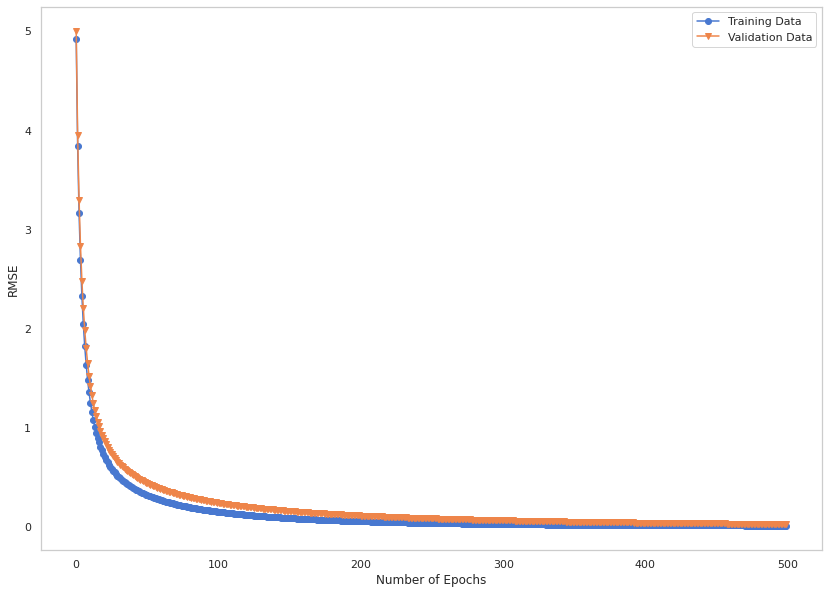

In [14]:
plt.plot(range(recom.n_epochs), recom.train_error, marker='o', label='Training Data');
plt.plot(range(recom.n_epochs), recom.val_error, marker='v', label='Validation Data');
plt.xlabel('Number of Epochs');
plt.ylabel('RMSE');
plt.legend()
plt.grid()
plt.show()

In [23]:
user_id = ratings_df.sample(1).index[0]
user_index = ratings_df.index.get_loc(user_id)
pred_index = np.where(train[user_index, :]==0)
pred_ind

1654